     |████████████████████████████████| 58.4MB 49kB/s 
     |████████████████████████████████| 3.3MB 54.4MB/s 
     |████████████████████████████████| 573kB 51.0MB/s 
     |████████████████████████████████| 12.2MB 53.9MB/s 
ERROR: xarray 0.15.1 has requirement numpy>=1.15, but you'll have numpy 1.14.5 which is incompatible.
ERROR: xarray 0.15.1 has requirement setuptools>=41.2, but you'll have setuptools 39.1.0 which is incompatible.
ERROR: umap-learn 0.4.1 has requirement numpy>=1.15, but you'll have numpy 1.14.5 which is incompatible.
ERROR: spacy 2.2.4 has requirement numpy>=1.15.0, but you'll have numpy 1.14.5 which is incompatible.
ERROR: plotnine 0.6.0 has requirement numpy>=1.16.0, but you'll have numpy 1.14.5 which is incompatible.
ERROR: numba 0.48.0 has requirement numpy>=1.15, but you'll have numpy 1.14.5 which is incompatible.
ERROR: imgaug 0.2.9 has requirement numpy>=1.15.0, but you'll have numpy 1.14.5 which is incompatible.
ERROR: google-auth 1.7.2 has requirement setup

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or 

--------------------- SES training loss --------------------
Loss at step 000: 0.540, alpha: 0.535, initial level: -0.442
Loss at step 020: 1.079, alpha: 0.557, initial level: -0.442
Loss at step 040: 1.079, alpha: 0.562, initial level: -0.442
Loss at step 060: 1.080, alpha: 0.563, initial level: -0.442
Loss at step 080: 1.080, alpha: 0.562, initial level: -0.442
Loss at step 100: 1.080, alpha: 0.562, initial level: -0.442
Loss at step 120: 1.080, alpha: 0.562, initial level: -0.442
Loss at step 140: 1.080, alpha: 0.562, initial level: -0.442
Loss at step 160: 1.080, alpha: 0.562, initial level: -0.442
Loss at step 180: 1.080, alpha: 0.562, initial level: -0.442
Loss at step 200: 1.080, alpha: 0.562, initial level: -0.442
Loss at step 220: 1.080, alpha: 0.562, initial level: -0.442
Loss at step 240: 1.080, alpha: 0.562, initial level: -0.442
Loss at step 260: 1.080, alpha: 0.562, initial level: -0.442
Loss at step 280: 1.080, alpha: 0.562, initial level: -0.442
Loss at step 300: 1.080,

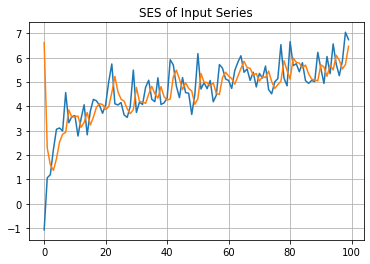

In [1]:
!pip install tensorflow==1.10.1
!pip install numpy==1.14.5 

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
tf.enable_eager_execution()

class SES(tf.keras.layers.Layer):
    def __init__(self, dtype=tf.float32):
        super(SES, self).__init__()
    
    def build(self, input_shape):
        self.alpha = self.add_weight('alpha', shape=[1,], 
                                     initializer=tf.keras.initializers.random_uniform(0,1), 
                                     constraint=tf.keras.constraints.min_max_norm(0,1))
        
        self.level = self.add_weight('level', shape=[1,], 
                                     initializer=tf.keras.initializers.truncated_normal())
        
    def call(self, input):
        
        def ses(y, alpha, level):
            '''Simple exponential smoothing using component form
            from Forecasting: Principles and Practice - Hyndman and George Athanasopoulos'''
            forecast = level
            updated_level = forecast + alpha * (y - forecast)
            return forecast, updated_level
        
        predictions = []
        for time_step in range(input.shape[0]):
            prediction, self.level = ses(input[time_step], self.alpha, self.level)
            predictions.append(prediction)
         
        return tf.concat(predictions, axis=-1)

# define mean squared loss function for simple exponential smoothing
def ses_loss(prediction, y):
    loss = tf.losses.mean_squared_error(labels=y, predictions=prediction, weights=1)
    return loss

if __name__ == "__main__":
    
    #define input series to be learned e.g. log with noise
    y = np.log(np.arange(1,300,3))+np.random.normal(0,0.6,100)
    
    #define tensorflow dataset
    y_values = tf.data.Dataset.from_tensor_slices(y).batch(batch_size=y.shape[0])
    
    #training parameters
    training_epochs = 500
    learning_rate = 0.01
    optimizer = tf.train.AdamOptimizer(learning_rate)

    loss_history = []
    
    #call SES layer
    ses_layer = SES()

    print('--------------------- SES training loss --------------------')
    for epoch in range(training_epochs):
        for yi in y_values:
            with tf.GradientTape() as tape:
                prediction = ses_layer(yi)
                loss = ses_loss(prediction, yi)

            loss_history.append(loss.numpy())
            grads = tape.gradient(loss, ses_layer.trainable_weights)
            optimizer.apply_gradients(zip(grads, ses_layer.trainable_weights), 
                                      global_step=None)
        
            if epoch % 20 == 0:
                print("Loss at step {:03d}: {:.3f}, alpha: {:.3f}, initial level: {:.3f}".format(epoch, loss, 
                      ses_layer.weights[0].numpy()[0],
                      ses_layer.weights[1].numpy()[0]))

    print("Final loss: {:.3f}".format(loss))
    print("alpha = {:.3f}, initial level = {:.3f}".format(ses_layer.weights[0].numpy()[0], 
          ses_layer.weights[1].numpy()[0]))
    
    plt.title('SES of Input Series')
    plt.plot(y)
    plt.plot(prediction.numpy())
    plt.grid(True)